# A comparison of 10k cohort thrombolysis rates across hospitals, and comparison with hospital SHAP values

## Plain English summary

In response to stroke teams being told that they are performing differently from other, they often state that this is due to them having a different set of patients.

This does have some truth to it. For example the hospitals in London will have younger patients, arriving sooner than compared to hospitals in more rural locations.

In order to remove patient differences from results, a common 10k cohort of patients will be used with each of the hospital models. That way any difference is due to hospital factors, and not patient factors.

The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45% across the 132 hospitals. The size of the hospital only accounted for 10% of the variation in thrombolysis use, and so there are other factors that account for the remaining 90%.

We find that predicted 10k thrombolysis use correlates very highly with average hopsital SHAP values.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 8 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Compare the thrombolysis rate across the 132 hospitals. This can be seen as comparing the hosptial effect, as the patient factors have been removed.
* Compare 10k thrombolysis use with average hopsital SHAP.
* Save thrombolysis rate at each hospital for the 10k patient cohort (for use in next notebook).

## Observations
* The 10k cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing (84.7%, see notebook 02).
* The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Only 10% of the variability in hospital thrombolysis rate can be explained by the hospital admission rate.# A comparison of 10k cohort thrombolysis rates across hospitals

## Plain English summary

In response to stroke teams being told that they are performing differently from other, they often state that this is due to them having a different set of patients.

This does have some truth to it. For example the hospitals in London will have younger patients, arriving sooner than compared to hospitals in more rural locations.

In order to remove patient differences from results, a common 10k cohort of patients will be used with each of the hospital models. That way any difference is due to hospital factors, and not patient factors.

The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45% across the 132 hospitals. The size of the hospital only accounted for 10% of the variation in thrombolysis use, and so there are other factors that account for the remaining 90%.

## Model and data

An XGBoost model is trained on all but a 10k patient cohort, to predict which patient will recieve thrombolysis.The 10k patient cohort is then used in two ways: 1) as the test set for the model fitting process 2) as a common set of patients that are sent to each hospital in turn to obtain a thrombolysis rate that is comparable across hosptials which has any patient factors removed.

The XGBoost model is fitted to all but 10k instances, and uses 8 features: 

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

## Aims:

* Train XGBoost model on all data except for a 10k set of patients
* Predict use of thrombolysis in the heldback 10k cohort of patients, at each of the 132 hospitals (by changing hospital one-hot coding).
* Compare the thrombolysis rate across the 132 hospitals. This can be seen as comparing the hosptial effect, as the patient factors have been removed.
* Save thrombolysis rate at each hospital for the 10k patient cohort (for use in next notebook).

## Observations
* The 10k cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing (84.7%, see notebook 02).
* The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Only 10% of the variability in hospital thrombolysis rate can be explained by the hospital admission rate.

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import shap

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Create output folders if needed

In [2]:
path = './output'
if not os.path.exists(path):
    os.makedirs(path)
    
path = './predictions'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [4]:
data_loc = '../data/10k_training_test/'

In [5]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=feature_name_dict, inplace=True)
test = test[key_features]
test.rename(columns=feature_name_dict, inplace=True)

# Store admissions per hospital
df_admissions = pd.DataFrame(index=np.unique(train["Stroke team"], return_counts=True)[0])
df_admissions[f"Admissions"] = np.unique(train["Stroke team"], return_counts=True)[1]

## Fit XGBoost model

Train a XGBoost model on the 10k cohort train/test dataset

In [6]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.841


Calculate receiver operating characteristic curve area under curve.

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print (f'ROC ACUC: {roc_auc:.3f}')

ROC ACUC: 0.913


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [8]:
hospitals = list(set(train['Stroke team']))
hospitals.sort()
thrombolysis_rate = []
single_predictions = []

for hospital in hospitals:
    
    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)
    
    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    thrombolysis_rate.append(y_pred.mean())
    
    # Save predictions
    single_predictions.append(y_pred * 1)

In [9]:
# Convert individual predictions (a list of arrays) to a NumPy array, and transpose
patient_results = np.array(single_predictions).T
# Convert to DataFrame
patient_results = pd.DataFrame(patient_results)
patient_results.to_csv('./output/10k_individual_predictions.csv', index=False)

Sort by hospital 10k thrombolysis rate.

In [10]:
thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', inplace=True, ascending=False)

# Save
thrombolysis_by_hosp.to_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_label='stroke_team')

### Plot thrombolysis rate of 10k cohort at each hospital

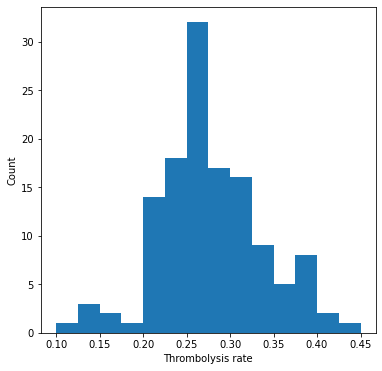

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_rate, bins=np.arange(0.10, 0.46, 0.025))
ax.set_xlabel('Thrombolysis rate')
ax.set_ylabel('Count')
plt.show()

### Show stats

In [12]:
mean = np.mean(thrombolysis_by_hosp['Thrombolysis rate'])
stdev = np.std(thrombolysis_by_hosp['Thrombolysis rate'])
minimum = np.min(thrombolysis_by_hosp['Thrombolysis rate'])
maximum = np.max(thrombolysis_by_hosp['Thrombolysis rate'])

print (f'Mean: {mean:0.3f}')
print (f'StDev: {stdev:0.3f}')
print (f'Min: {minimum:0.3f}')
print (f'Max{maximum:0.3f}')

Mean: 0.275
StDev: 0.067
Min: 0.096
Max0.461


## Plot thrombolysis rate vs unit size

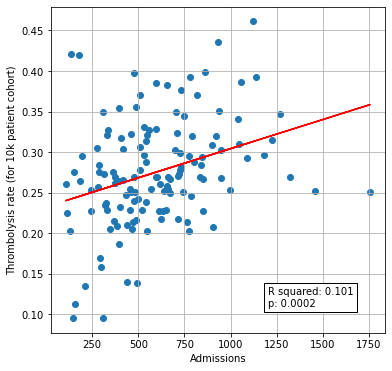

In [13]:
# Join dataframes together (on index)
thrombolysis_by_hosp = thrombolysis_by_hosp.join(df_admissions["Admissions"])

# Setup data for chart

x = np.array(thrombolysis_by_hosp['Admissions']).reshape(-1, 1)
y = np.array(thrombolysis_by_hosp['Thrombolysis rate']).reshape(-1, 1)

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x.flatten(),y.flatten())
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(1200, 0.11, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Admissions')
ax1.set_ylabel('Thrombolysis rate (for 10k patient cohort)')
plt.grid()
plt.savefig('./output/units_size_10k_thrombolysis.jpg', dpi=300)

plt.show()

## Compare level of agreement between hospitals 

In this section we look at how many hospitals agree on whether to give each patient in the 10k cohort thrombolysis or not.

Collating individual predictions:

In [14]:
# Set up data frame and get the number and percent hopsitals giving thrombolysis
agreement = pd.DataFrame()
agreement['sum'] = patient_results.sum(axis=1)
agreement['percent'] = agreement['sum'] * 100 / patient_results.shape[1]
# Percent agree can be to give thrombolysis (p) or not (100-p)
agreement['percent_agree'] = [max(p, 100-p) for p in agreement['percent']]
# Add in whether thrombolysis was actually given
agreement['True'] = y_test

Plot results:

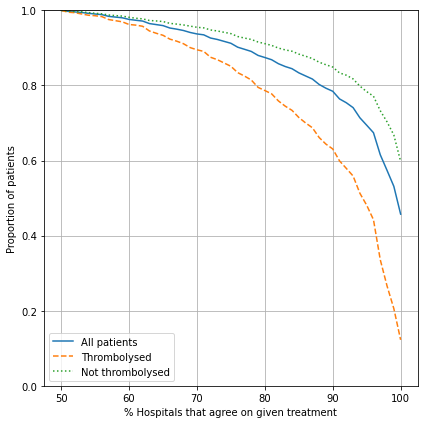

In [15]:
fig = plt.figure(figsize=(6,6))

# Agreement on treatment 
ax1 = fig.add_subplot(111)
xvals = np.arange(50,101,1)

y1 = [sum([1 for p in agreement.percent_agree.values if p>=x])\
         /len(agreement.percent_agree.values) for x in xvals]

ax1.plot(xvals, y1, label='All patients', linestyle='-')

y2 = [sum(1 for p in agreement[agreement['True']==1].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==1].percent_agree.values) for x in xvals]

ax1.plot(xvals, y2, label='Thrombolysed', linestyle='--')

y3 = [sum(1 for p in agreement[agreement['True']==0].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==0].percent_agree.values) for x in xvals]
      
ax1.plot(xvals, y3, label='Not thrombolysed', linestyle=':')
         
ax1.legend()

ax1.set_xlabel('% Hospitals that agree on given treatment')
ax1.set_ylabel('Proportion of patients')
ax1.set_ylim(0, 1)
ax1.grid()
      
plt.tight_layout()
plt.savefig('./output/agreement_x_hospital_single.jpg', dpi=300)
plt.show()

Show statistics:

In [16]:
# Set percent of hospital to agree
xvals = [80, 90, 95]

# Find proportion of patients with agreement for either treat/no-treat decsion
agree_all = [sum([1 for p in agreement.percent_agree.values if p>=x])\
         /len(agreement.percent_agree.values) for x in xvals]

# Find proportion of thrombolysed patients with agreement
agree_thromb = [
    sum(1 for p in agreement[agreement['True']==1].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==1].percent_agree.values) for x in xvals]

# Find proportion of non-thrombolysed patients with agreement
agree_non_thromb = [
    sum(1 for p in agreement[agreement['True']==0].percent_agree.values if p>=x)\
         /len(agreement[agreement['True']==0].percent_agree.values) for x in xvals]

# Put in DataFrame
results_agree = pd.DataFrame()
results_agree['% Hospitals Agree'] = xvals
results_agree.set_index('% Hospitals Agree', inplace=True)
results_agree['Any'] = agree_all
results_agree['Patient thrombolysed'] = agree_thromb
results_agree['Patient not thrombolysed'] = agree_non_thromb
results_agree = results_agree.round(3)

results_agree

,Any,Patient thrombolysed,Patient not thrombolysed
% Hospitals Agree,,,
80,0.874,0.787,0.911
90,0.785,0.631,0.849
95,0.694,0.481,0.784


In the table above, for example, 87.4% of patients have 80% of hospitals agree on treatment. For those patients that did actually receive thrombolysis, 78.8% of patients have 80% of hospitals agree to thrombolyse. For those patients that did not actually receive thrombolysis, 91.1% of patients have 80% of hospitals agree not to thrombolyse. 

## Compare SHAP value for the hospital feature, and the predicted 10k thrombolysis rate

The hospital feature is one hot encoded, so there is a SHAP value per stroke team. We will use this to create two plots:

1) histogram of the frequency of the SHAP value for the hospital feature
2) scatter plot of SHAP value vs thrombolysis rate (on 10K cohort) for each hospital

### Fit SHAP model

In [17]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)
# Get (and store) Shapley values along with base and feature values
shap_values_extended = explainer(X_test)
shap_values = shap_values_extended.values

 99%|===================| 9855/10000 [00:18<00:00]        

### Get average SHAP for each hopsital (from test set SHAP values)

In [18]:
stroke_teams = list(np.unique(test['Stroke team']))
hospital_mean_shaps = []
features = list(X_train)
test_stroke_team = test['Stroke team']

for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = test_stroke_team == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = features.index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Get mean
    mean_shap = np.mean(stroke_team_shap)
    # Store mean
    hospital_mean_shaps.append(mean_shap)
    
hospital_shap_df = pd.DataFrame(index=stroke_teams)
hospital_shap_df['mean SHAP'] = hospital_mean_shaps

Combine with 10k thrombolysis rate.

In [19]:
thrombolysis_by_hosp = thrombolysis_by_hosp.merge(
    hospital_shap_df, left_index=True, right_index=True)

Plot histogram of average hospital SHAP.

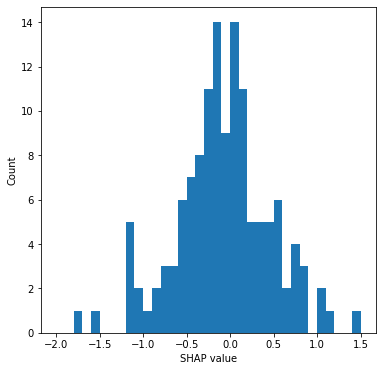

In [20]:
# Plot histogram
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(thrombolysis_by_hosp["mean SHAP"], bins=np.arange(-2, 1.51, 0.1))
ax.set_xlabel('SHAP value')
ax.set_ylabel('Count')
plt.savefig('./output/hosp_shap_hist.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)
plt.show()

Plot scatter plot of comparison between average hospital SHAP and predicted 10k thrombolysis use. 

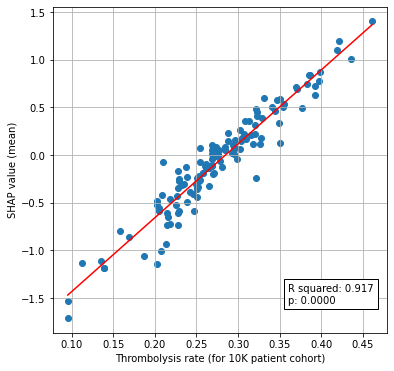

In [21]:
# Plot scatter plot
x = thrombolysis_by_hosp['Thrombolysis rate']
y = thrombolysis_by_hosp["mean SHAP"]

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x.values,y.values)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(0.36, -1.55, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Thrombolysis rate (for 10K patient cohort)')
ax1.set_ylabel('SHAP value (mean)')
plt.grid()
plt.savefig('./output/scatter_plot_hosp_shap_vs_10k_thrombolysis.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

plt.show()

## Observations

* The 10k cohort model had an accuracy of 85.2%, in line with accuracy from k-fold testing.
* The predicted thrombolysis use in the 10k cohort of patients ranged from 10% to 45%.
* Only 10% of the variability in hospital thrombolysis rate can be explained by the hospital admission rate.

It is easier to find majority agreement on who not to thrombolyse than who to thrombolyse. For example:

 * 87.4% of all patients have a treatment decision that is agreed by 80% hospitals
 * Of those who were not given thrombolysis, 84.1% had agreement by 80% hospitals
 * Of those who were given thrombolysis, 78.8% had agreement by 80% hospitals
 
 Thrombolysis rate of 10k cohort correlates weakly with unit size.
 
 10k thrombolysis rate correlates closely with average hospital SHAP value.